In [2]:
import torch
from utils import HelicoDatasetClassification, HelicoDatasetPatientDiagnosis
from model import HelicobacterClassifier    
torch.manual_seed(42)
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:

for n in range(5):
    model = HelicobacterClassifier()
    model.load_state_dict(torch.load(r"C:\Users\Usuario\Documents\GitHub\MED-GIA\Classfication\models\HelicobacterClassifier_fold" + str(n) + ".pth"))
    globals()[f'model_fold_{n}'] = model

# Ensemble voting to predict new patches
def ensemble_predict(models, img):
    outputs = [torch.softmax(model(img), dim=1) for model in models] # Get probabilities [0.1,0.9]
    outputs = torch.stack(outputs) # Stack probabilities [[0.1,0.9],[0.2,0.8]]
    outputs = torch.mean(outputs, dim=0) # Average probabilities [0.15,0.85]
    _, predicted = torch.max(outputs.data, 1) # Get the index of the max probability
    return predicted

# Load models into a list
models = [globals()[f'model_fold_{n}'] for n in range(5)]

#------------------------------------------------------------------------------

# Predict using ensemble
"""ensemble_predictions = []
loader_to_predict = DataLoader(dataset, batch_size=1, shuffle=False) 
for i, data in enumerate(loader_to_predict):
    img, label = data
    img = img.to(device)
    label = label.to(device)
    predicted = ensemble_predict(models, img)
    ensemble_predictions.append(predicted.cpu().numpy())
ensemble_predictions = np.concatenate(ensemble_predictions)"""

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11752\1170566858.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\Usuario\Docume

'ensemble_predictions = []\nloader_to_predict = DataLoader(dataset, batch_size=1, shuffle=False) \nfor i, data in enumerate(loader_to_predict):\n    img, label = data\n    img = img.to(device)\n    label = label.to(device)\n    predicted = ensemble_predict(models, img)\n    ensemble_predictions.append(predicted.cpu().numpy())\nensemble_predictions = np.concatenate(ensemble_predictions)'

In [66]:
import pandas as pd 
path_to_annotated = r'C:\Users\Usuario\Documents\GitHub\MED-GIA\data\HelicoDataSet\HP_WSI-CoordAnnotatedPatches.xlsx'
path_to_Patient_Diagnois = r'C:\Users\Usuario\Documents\GitHub\MED-GIA\data\HelicoDataSet\PatientDiagnosis.csv'
patient_diagnosisDF = pd.read_csv(path_to_Patient_Diagnois)
annotated_patchesDF = pd.read_excel(path_to_annotated) 

print(patient_diagnosisDF.head())
print(annotated_patchesDF.head())

patient_diagnosisDF = patient_diagnosisDF[(patient_diagnosisDF['DENSITAT'] == 'ALTA') | (patient_diagnosisDF['DENSITAT'] == 'NEGATIVA')]
annotated_patchesDF = annotated_patchesDF[annotated_patchesDF['Presence'] != 0]


# Group by patient_id and count the number of positive and negative patches
grouped = annotated_patchesDF.groupby(['Pat_ID'])
grouped = annotated_patchesDF.groupby('Pat_ID').agg(
    number_of_positive_patches=('Presence', lambda x: (x == 1).sum()),
    number_of_negative_patches=('Presence', lambda x: (x == -1).sum())
).reset_index()

# Inlcude in gropued pateint_diagnosisDF['DENSITAT'] based on the id
grouped.head()
grouped = grouped.merge(patient_diagnosisDF, left_on='Pat_ID', right_on='CODI', how='inner')
grouped.head()
grouped = grouped.drop(columns=['CODI'])

# OBJECTIVE  have a dataframe with the following columns: patient_id, number_of_positive_patches, number_of_negative_patches, diagnosis, prediction

     CODI  DENSITAT
0  B22-01     BAIXA
1  B22-02     BAIXA
2  B22-03  NEGATIVA
3  B22-04  NEGATIVA
4  B22-05  NEGATIVA
    Pat_ID  Section_ID Window_ID      i      j    h    w  Presence
0  B22-129           0       659   7477  11978  256  256        -1
1   B22-68           0       131   6597  12009  256  256        -1
2   B22-68           0       141   5100  10737  256  256        -1
3   B22-68           0       290   5015  14908  256  256        -1
4   B22-68           0       298  11626  13928  256  256        -1


In [72]:
print(patient_diagnosisDF)

densitat = patient_diagnosisDF [patient_diagnosisDF['CODI'] == "B22-03"]
print(list(densitat['DENSITAT']))

        CODI  DENSITAT
2     B22-03  NEGATIVA
3     B22-04  NEGATIVA
4     B22-05  NEGATIVA
5     B22-06  NEGATIVA
6     B22-07  NEGATIVA
..       ...       ...
304  B22-311      ALTA
305  B22-312      ALTA
306  B22-313      ALTA
307  B22-314  NEGATIVA
308  B22-315  NEGATIVA

[237 rows x 2 columns]
['NEGATIVA']


In [63]:
import pathlib 
grouped


# Create a pathlib object to store the results

path_to_holdout =  r"C:/Users/Usuario/Documents/GitHub/MED-GIA/data/HelicoDataSet/HoldOut"
# iterate over the directories in holdout  and include the name of the directory in a list
holdout_directories = [x for x in pathlib.Path(path_to_holdout).iterdir() if x.is_dir()]

# Extract the name of the directories without the full path
holdout_directories = [x.name[:-2] for x in holdout_directories]

holdout_directories

['B22-01',
 'B22-02',
 'B22-03',
 'B22-04',
 'B22-05',
 'B22-06',
 'B22-07',
 'B22-08',
 'B22-09',
 'B22-100',
 'B22-105',
 'B22-10',
 'B22-11',
 'B22-120',
 'B22-128',
 'B22-12',
 'B22-130',
 'B22-132',
 'B22-134',
 'B22-135',
 'B22-136',
 'B22-139',
 'B22-13',
 'B22-146',
 'B22-14',
 'B22-159',
 'B22-15',
 'B22-161',
 'B22-169',
 'B22-16',
 'B22-17',
 'B22-18',
 'B22-196',
 'B22-198',
 'B22-199',
 'B22-19',
 'B22-201',
 'B22-202',
 'B22-203',
 'B22-205',
 'B22-206',
 'B22-207',
 'B22-208',
 'B22-209',
 'B22-20',
 'B22-211',
 'B22-212',
 'B22-213',
 'B22-215',
 'B22-220',
 'B22-222',
 'B22-224',
 'B22-225',
 'B22-226',
 'B22-227',
 'B22-229',
 'B22-231',
 'B22-233',
 'B22-236',
 'B22-237',
 'B22-238',
 'B22-239',
 'B22-242',
 'B22-243',
 'B22-246',
 'B22-247',
 'B22-252',
 'B22-255',
 'B22-257',
 'B22-259',
 'B22-261',
 'B22-262',
 'B22-263',
 'B22-266',
 'B22-267',
 'B22-268',
 'B22-269',
 'B22-271',
 'B22-272',
 'B22-273',
 'B22-281',
 'B22-282',
 'B22-283',
 'B22-285',
 'B22-286',


In [5]:
from PIL import Image
import pathlib
import pandas as pd
import torchvision
import numpy as np


def transform_image(image, size):
    return image.resize(size)

class HoldoutDataset():
    def __init__(self):
        path_to_holdout = r"C:/Users/Usuario/Documents/GitHub/MED-GIA/data/HelicoDataSet/HoldOut"
        patient_directories = [patient for patient in pathlib.Path(path_to_holdout).iterdir()]
        path_to_Patient_Diagnois = r'C:\Users\Usuario\Documents\GitHub\MED-GIA\data\HelicoDataSet\PatientDiagnosis.csv'
        patient_diagnosisDF = pd.read_csv(path_to_Patient_Diagnois)
        patient_diagnosisDF = patient_diagnosisDF[(patient_diagnosisDF['DENSITAT'] == 'ALTA') | (patient_diagnosisDF['DENSITAT'] == 'NEGATIVA')]
        patient_diagnosisDF['DENSITAT'] = [1 if x == 'ALTA' else -1 for x in patient_diagnosisDF['DENSITAT']]
        patient_diagnosisDF = patient_diagnosisDF.rename(columns={'DENSITAT': 'DiagnosisGT'})
        
        self.dictionary = {}
        
        for patient in patient_directories:
            if patient.name[:-2] in patient_diagnosisDF['CODI'].values:
                images = [x for x in patient.iterdir() if x.is_file() and x.name.endswith('.png')]
                self.dictionary[patient.name[:-2]] = (images, patient_diagnosisDF[patient_diagnosisDF['CODI'] == patient.name[:-2]]['DiagnosisGT'].values)
        
    def __len__(self):
        return len(self.dictionary)
    
    def __getitem__(self, idx):
        patient_id = list(self.dictionary.keys())[idx]
        images, patient_diagnosis = self.dictionary[patient_id]
        transformed_images = [transform_image(Image.open(image_path).convert("RGB"), (256, 256)) for image_path in images]
        return transformed_images, patient_id, patient_diagnosis


holdout_dataset = HoldoutDataset() 

Processing patients:   0%|          | 0/82 [00:00<?, ?it/s]

Processing patients: 100%|██████████| 82/82 [22:10<00:00, 16.22s/it]


Confusion Matrix:
[[57  1]
 [15  9]]


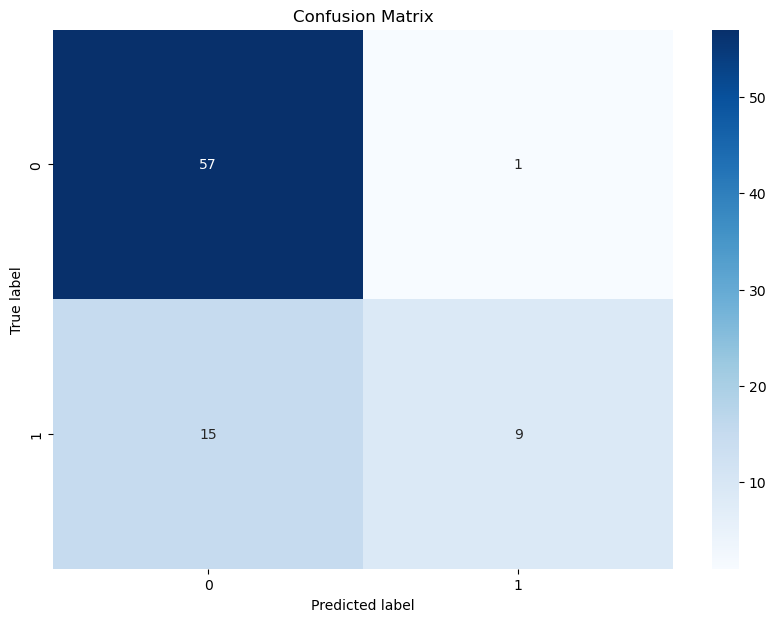

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader
from tqdm import tqdm


for n in range(5):
    model = HelicobacterClassifier()
    model.load_state_dict(torch.load(r"C:\Users\Usuario\Documents\GitHub\MED-GIA\Classfication\models\HelicobacterClassifier_fold" + str(n) + ".pth"))
    globals()[f'model_fold_{n}'] = model

# Ensemble voting to predict new patches
def ensemble_predict(models, img):
    outputs = [torch.softmax(model(img), dim=1) for model in models] # Get probabilities [0.1,0.9]
    outputs = torch.stack(outputs) # Stack probabilities [[0.1,0.9],[0.2,0.8]]
    outputs = torch.mean(outputs, dim=0) # Average probabilities [0.15,0.85]
    _, predicted = torch.max(outputs.data, 1) # Get the index of the max probability
    return predicted

# Load models into a list
models = [globals()[f'model_fold_{n}'] for n in range(5)]

# Move models to the same device as the input tensor
models = [model.to(device) for model in models]

#--------------------------------------------------------------

# Create a DataLoader for the holdout dataset
holdout_loader = DataLoader(holdout_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: x)

# Predict diagnosis for each patient using ensemble
predictions = []
ground_truth = []

for data in tqdm(holdout_loader, desc="Processing patients"):
    data = data[0]  # Remove batch dimension
    images, patient_id, patient_diagnosis = data
    images = torch.stack([torchvision.transforms.ToTensor()(image) for image in images])
    images = images.to(device)
    
    # Predict for each image
    positive_patch_found = False
    for img in images:
        img = img.unsqueeze(0)  # Add batch dimension
        predicted = ensemble_predict(models, img)
        if predicted.item() == 1:  # If any patch is positive
            positive_patch_found = True
            break
    
    # If a positive patch is found, the diagnosis is positive (1), otherwise negative (-1)
    final_prediction = 1 if positive_patch_found else -1
    predictions.append(final_prediction)
    ground_truth.append(patient_diagnosis[0].item())

# Compute confusion matrix
conf_matrix = confusion_matrix(ground_truth, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [35]:
from sklearn.metrics import classification_report

# Compute classification report
class_report = classification_report(ground_truth, predictions, target_names=['Negative', 'Positive'])
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.98      0.88        58
    Positive       0.90      0.38      0.53        24

    accuracy                           0.80        82
   macro avg       0.85      0.68      0.70        82
weighted avg       0.82      0.80      0.78        82



Try using the most confidence one. 

Processing patients: 100%|██████████| 82/82 [21:49<00:00, 15.97s/it]


Confusion Matrix:
[[57  1]
 [14 10]]


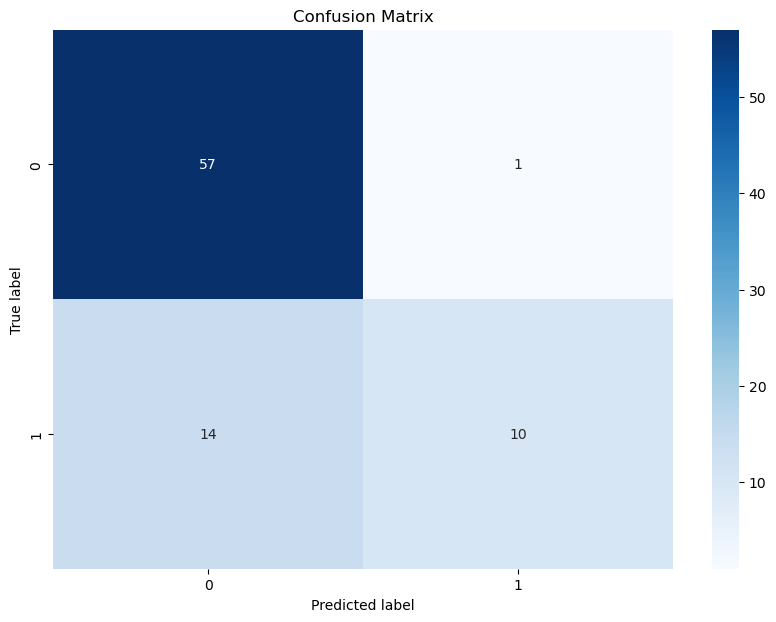

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader
from tqdm import tqdm

# Ensemble voting to predict new patches
def ensemble_predict(models, img):
    outputs = [torch.softmax(model(img), dim=1) for model in models]  # Get probabilities [0.1,0.9]
    max_confidences = [torch.max(output).item() for output in outputs]  # Get max confidence for each model
    best_model_index = max_confidences.index(max(max_confidences))  # Find the index of the model with the highest confidence
    _, predicted = torch.max(outputs[best_model_index].data, 1)  # Get the prediction of the best model
    return predicted

# Load models into a list
models = [globals()[f'model_fold_{n}'] for n in range(5)]

# Move models to the same device as the input tensor
models = [model.to(device) for model in models]

#--------------------------------------------------------------

# Create a DataLoader for the holdout dataset
holdout_loader = DataLoader(holdout_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: x)

# Predict diagnosis for each patient using ensemble
predictions = []
ground_truth = []

for data in tqdm(holdout_loader, desc="Processing patients"):
    data = data[0]  # Remove batch dimension
    images, patient_id, patient_diagnosis = data
    images = torch.stack([torchvision.transforms.ToTensor()(image) for image in images])
    images = images.to(device)
    
    # Predict for each image
    positive_patch_found = False
    for img in images:
        img = img.unsqueeze(0)  # Add batch dimension
        predicted = ensemble_predict(models, img)
        if predicted.item() == 1:  # If any patch is positive
            positive_patch_found = True
            break
    
    # If a positive patch is found, the diagnosis is positive (1), otherwise negative (-1)
    final_prediction = 1 if positive_patch_found else -1
    predictions.append(final_prediction)
    ground_truth.append(patient_diagnosis[0].item())

# Compute confusion matrix
conf_matrix = confusion_matrix(ground_truth, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [7]:
from sklearn.metrics import classification_report

# Compute classification report
class_report = classification_report(ground_truth, predictions, target_names=['Negative', 'Positive'])
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.98      0.88        58
    Positive       0.91      0.42      0.57        24

    accuracy                           0.82        82
   macro avg       0.86      0.70      0.73        82
weighted avg       0.83      0.82      0.79        82



Try using the pondered sum. 


Processing patients: 100%|██████████| 82/82 [19:27<00:00, 14.23s/it]


Confusion Matrix:
[[57  1]
 [15  9]]


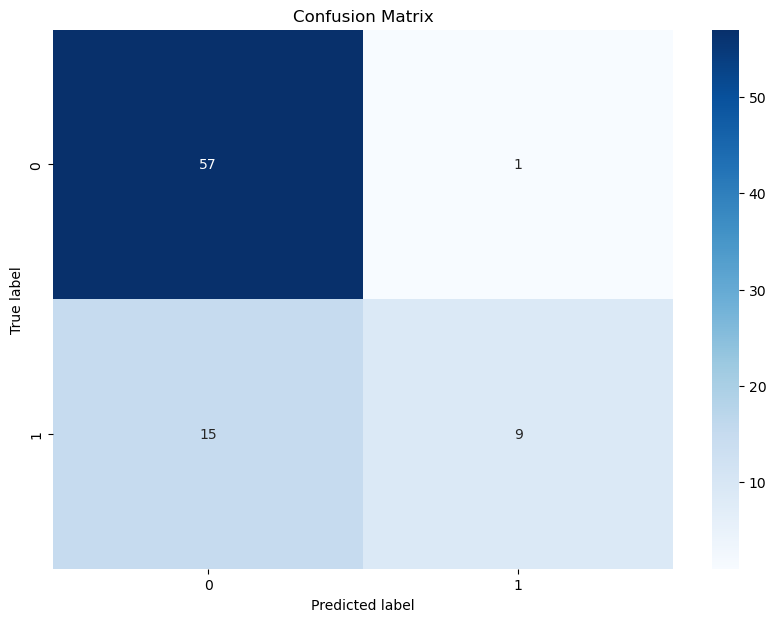

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader
from tqdm import tqdm

# Ensemble voting to predict new patches
def ensemble_predict(models, img):
    outputs = [torch.softmax(model(img), dim=1) for model in models]  # Get probabilities [0.1,0.9]
    confidences = [torch.max(output).item() for output in outputs]  # Get max confidence for each model
    weighted_outputs = [output * confidence for output, confidence in zip(outputs, confidences)]  # Weight outputs by confidence
    summed_outputs = torch.sum(torch.stack(weighted_outputs), dim=0)  # Sum weighted outputs
    _, predicted = torch.max(summed_outputs.data, 1)  # Get the prediction with the highest weighted sum
    return predicted

# Load models into a list
models = [globals()[f'model_fold_{n}'] for n in range(5)]

# Move models to the same device as the input tensor
models = [model.to(device) for model in models]

#--------------------------------------------------------------

# Create a DataLoader for the holdout dataset
holdout_loader = DataLoader(holdout_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: x)

# Predict diagnosis for each patient using ensemble
predictions = []
ground_truth = []

for data in tqdm(holdout_loader, desc="Processing patients"):
    data = data[0]  # Remove batch dimension
    images, patient_id, patient_diagnosis = data
    images = torch.stack([torchvision.transforms.ToTensor()(image) for image in images])
    images = images.to(device)
    
    # Predict for each image
    positive_patch_found = False
    for img in images:
        img = img.unsqueeze(0)  # Add batch dimension
        predicted = ensemble_predict(models, img)
        if predicted.item() == 1:  # If any patch is positive
            positive_patch_found = True
            break
    
    # If a positive patch is found, the diagnosis is positive (1), otherwise negative (-1)
    final_prediction = 1 if positive_patch_found else -1
    predictions.append(final_prediction)
    ground_truth.append(patient_diagnosis[0].item())

# Compute confusion matrix
conf_matrix = confusion_matrix(ground_truth, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [9]:
from sklearn.metrics import classification_report

# Compute classification report
class_report = classification_report(ground_truth, predictions, target_names=['Negative', 'Positive'])
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.98      0.88        58
    Positive       0.90      0.38      0.53        24

    accuracy                           0.80        82
   macro avg       0.85      0.68      0.70        82
weighted avg       0.82      0.80      0.78        82

